<a href="https://colab.research.google.com/github/carlacodes/atchekegroup1lunarlanding/blob/hasan/Copy_of_Exporting_module(Late%20night%20version).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Install dependencies
!sudo apt-get update > /dev/null 2>&1
!sudo apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install rarfile --quiet
!pip install stable-baselines3[extra] ale-py==0.7.4 --quiet
!pip install box2d-py --quiet
!pip install gym pyvirtualdisplay --quiet


     |████████████████████████████████| 177 kB 19.7 MB/s 
     |████████████████████████████████| 1.6 MB 5.5 MB/s 
     |████████████████████████████████| 1.5 MB 42.3 MB/s 
     |████████████████████████████████| 1.1 MB 56.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 448 kB 31.9 MB/s 


In [2]:
# Imports
import io
import os
import glob
import torch
import base64
import stable_baselines3

import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import DQN
from stable_baselines3.common.results_plotter import ts2xy, load_results
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_atari_env

import gym
from gym import spaces
from gym.wrappers import Monitor,RecordVideo

In [3]:
print(gym.__version__)

0.21.0


In [4]:
# @title Plotting/Video functions
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


def wrap_env(env):
  env = Monitor(env, './video', force=True)
  # env = RecordVideo(env, './video')
  return env

In [5]:
nn_layers = [64,64] #This is the configuration of your neural network. Currently, we have two layers, each consisting of 64 neurons.
                    #If you want three layers with 64 neurons each, set the value to [64,64,64] and so on.

learning_rate = 0.001 #This is the step-size with which the gradient descent is carried out.
                      #Tip: Use smaller step-sizes for larger networks.

# Importing the obstacle Env for Fine tuning 

In [6]:
from gym.envs.box2d import LunarLander
from Box2D.b2 import fixtureDef, circleShape, polygonShape, revoluteJointDef, contactListener, edgeShape
import math

In [7]:
FPS = 50
SCALE = 30.0  # affects how fast-paced the game is, forces should be adjusted as well

MAIN_ENGINE_POWER = 13.0
SIDE_ENGINE_POWER = 0.6

INITIAL_RANDOM = 1000.0  # Set 1500 to make game harder

LANDER_POLY = [(-14, +17), (-17, 0), (-17, -10), (+17, -10), (+17, 0), (+14, +17)]
LEG_AWAY = 20
LEG_DOWN = 18
LEG_W, LEG_H = 2, 8
LEG_SPRING_TORQUE = 40

SIDE_ENGINE_HEIGHT = 14.0
SIDE_ENGINE_AWAY = 12.0

VIEWPORT_W = 600
VIEWPORT_H = 400

In [8]:
class ContactDetector(contactListener):
    def __init__(self, env):
        contactListener.__init__(self)
        self.env = env

    def BeginContact(self, contact):
        if (
                self.env.lander == contact.fixtureA.body
                or self.env.lander == contact.fixtureB.body
        ):
            self.env.game_over = True
        for i in range(2):
            if self.env.legs[i] in [contact.fixtureA.body, contact.fixtureB.body]:
                self.env.legs[i].ground_contact = True

    def EndContact(self, contact):
        for i in range(2):
            if self.env.legs[i] in [contact.fixtureA.body, contact.fixtureB.body]:
                self.env.legs[i].ground_contact = False

class Custom_LunarLander_obs(LunarLander):
    metadata = {"render.modes": ["human", "rgb_array"], "video.frames_per_second": FPS}
    continuous = False

    def __init__(
        self,
        enable_wind: bool = False,
        wind_power: float = 15.0,
        obs_coords = [10, 10],
        enable_obstacle: bool = True
    ):
        LunarLander.__init__(self)

        self.enable_wind = enable_wind

        self.obs_coords = obs_coords
        self.enable_obstacle = enable_obstacle
        self.wind_power = wind_power

        self.wind_idx = np.random.randint(-9999, 9999)

        # defining the polygon obstacle here:
        vertices_poly = [(5, 5), (5, 2), (2, 2), (2, 5)]  # may need to change later
        # self.obstacle = self.world.CreateStaticBody(
        #
        #     # shapes=polygonShape(centroid=(self.obs_coords[0] + VIEWPORT_W / 2 / SCALE,
        #     #                         self.obs_coords[1] + (self.helipad_y + LEG_DOWN / SCALE)),
        #     #                    vertices= [(x / SCALE, y / SCALE) for x, y in vertices_poly]),
        #     shapes=circleShape(pos=(self.obs_coords[0] + VIEWPORT_W / 2 / SCALE,
        #                             self.obs_coords[1] + (self.helipad_y + LEG_DOWN / SCALE)),
        #                        radius=2),
        #                         categoryBits=0x1000,
        #
        # )
        self.obstacle = self.world.CreateStaticBody(
            position=(self.obs_coords[0], self.obs_coords[1]),
            # (self.obs_coords[0] + VIEWPORT_W / 2 / SCALE,
            # self.obs_coords[1] + (self.helipad_y + LEG_DOWN / SCALE))
            angle=0.0,
            fixtures=fixtureDef(
                #circleShape(radius=2 / SCALE, pos=(0, 0)),
                shape=circleShape(radius=20 / SCALE, 
                                  pos=(self.obs_coords[0],
                                       self.obs_coords[1])),
                # density=5.0,
                # friction=0.1,
                # categoryBits=0x0010,
                # # maskBits=0x001,  # collide only with ground
                # restitution=0.0,
            ),  # 0.99 bouncy
        )

        self.obstacle.color1 = (0.5, 0.4, 0.9)
        self.obstacle.color2 = (1, 1, 1)
        # self.obstacle.alpha = 0.8  

        self.observation_space = spaces.Box(
            -np.inf, np.inf, shape=(8,), dtype=np.float32
        )   

    def reset(self):
        self._destroy()
        self.world.contactListener_keepref = ContactDetector(self)
        self.world.contactListener = self.world.contactListener_keepref
        self.game_over = False
        self.prev_shaping = None

        W = VIEWPORT_W / SCALE
        H = VIEWPORT_H / SCALE

        # terrain
        CHUNKS = 11
        height = self.np_random.uniform(0, H / 2, size=(CHUNKS + 1,))
        chunk_x = [W / (CHUNKS - 1) * i for i in range(CHUNKS)]
        self.helipad_x1 = chunk_x[CHUNKS // 2 - 1]
        self.helipad_x2 = chunk_x[CHUNKS // 2 + 1]
        self.helipad_y = H / 4
        height[CHUNKS // 2 - 2] = self.helipad_y
        height[CHUNKS // 2 - 1] = self.helipad_y
        height[CHUNKS // 2 + 0] = self.helipad_y
        height[CHUNKS // 2 + 1] = self.helipad_y
        height[CHUNKS // 2 + 2] = self.helipad_y
        smooth_y = [
            0.33 * (height[i - 1] + height[i + 0] + height[i + 1])
            for i in range(CHUNKS)
        ]

        self.moon = self.world.CreateStaticBody(
            shapes=edgeShape(vertices=[(0, 0), (W, 0)])
        )

        # defining the polygon obstacle here----------------------------------
        vertices_poly = [(5, 5), (5, 2), (2, 2), (2, 5)]  # may need to change later
        # self.obstacle = self.world.CreateStaticBody(
        #
        #     # shapes=polygonShape(centroid=(self.obs_coords[0] + VIEWPORT_W / 2 / SCALE,
        #     #                         self.obs_coords[1] + (self.helipad_y + LEG_DOWN / SCALE)),
        #     #                    vertices= [(x / SCALE, y / SCALE) for x, y in vertices_poly]),
        #     shapes=circleShape(pos=(self.obs_coords[0] + VIEWPORT_W / 2 / SCALE,
        #                             self.obs_coords[1] + (self.helipad_y + LEG_DOWN / SCALE)),
        #                        radius=2),
        #                         categoryBits=0x1000,
        #
        # )
        self.obstacle = self.world.CreateStaticBody(
            position=(self.obs_coords[0], self.obs_coords[1]),
            # (self.obs_coords[0] + VIEWPORT_W / 2 / SCALE,
            # self.obs_coords[1] + (self.helipad_y + LEG_DOWN / SCALE))
            angle=0.0,
            fixtures=fixtureDef(
                #circleShape(radius=2 / SCALE, pos=(0, 0)),
                shape=circleShape(radius=20 / SCALE, pos=(self.obs_coords[0],
                                       self.obs_coords[1])),
                # density=5.0,
                # friction=0.1,
                # categoryBits=0x0010,
                # # maskBits=0x001,  # collide only with ground
                # restitution=0.0,
            ),  # 0.99 bouncy
        )

        self.obstacle.color1 = (0.5, 0.4, 0.9)
        self.obstacle.color2 = (1, 1, 1)
        # self.obstacle.alpha = 0.8
        # ----------------------------------------------------------------

        self.sky_polys = []
        for i in range(CHUNKS - 1):
            p1 = (chunk_x[i], smooth_y[i])
            p2 = (chunk_x[i + 1], smooth_y[i + 1])
            self.moon.CreateEdgeFixture(vertices=[p1, p2], density=0, friction=0.1)
            self.sky_polys.append([p1, p2, (p2[0], H), (p1[0], H)])

        self.moon.color1 = (0.0, 0.0, 0.0)
        self.moon.color2 = (0.0, 0.0, 0.0)

        initial_y = VIEWPORT_H / SCALE
        self.lander = self.world.CreateDynamicBody(
            position=(VIEWPORT_W / SCALE / 2, initial_y),
            angle=0.0,
            fixtures=fixtureDef(
                shape=polygonShape(
                    vertices=[(x / SCALE, y / SCALE) for x, y in LANDER_POLY]
                ),
                density=5.0,
                friction=0.1,
                categoryBits=0x0010,
                maskBits=0x001,  # collide only with ground
                restitution=0.0,
            ),  # 0.99 bouncy
        )
        self.lander.color1 = (0.5, 0.4, 0.9)
        self.lander.color2 = (0.3, 0.3, 0.5)
        self.lander.ApplyForceToCenter(
            (
                self.np_random.uniform(-INITIAL_RANDOM, INITIAL_RANDOM),
                self.np_random.uniform(-INITIAL_RANDOM, INITIAL_RANDOM),
            ),
            True,
        )

        self.legs = []
        for i in [-1, +1]:
            leg = self.world.CreateDynamicBody(
                position=(VIEWPORT_W / SCALE / 2 - i * LEG_AWAY / SCALE, initial_y),
                angle=(i * 0.05),
                fixtures=fixtureDef(
                    shape=polygonShape(box=(LEG_W / SCALE, LEG_H / SCALE)),
                    density=1.0,
                    restitution=0.0,
                    categoryBits=0x0020,
                    maskBits=0x001,
                ),
            )
            leg.ground_contact = False
            leg.color1 = (0.5, 0.4, 0.9)
            leg.color2 = (0.3, 0.3, 0.5)
            rjd = revoluteJointDef(
                bodyA=self.lander,
                bodyB=leg,
                localAnchorA=(0, 0),
                localAnchorB=(i * LEG_AWAY / SCALE, LEG_DOWN / SCALE),
                enableMotor=True,
                enableLimit=True,
                maxMotorTorque=LEG_SPRING_TORQUE,
                motorSpeed=+0.3 * i,  # low enough not to jump back into the sky
            )
            if i == -1:
                rjd.lowerAngle = (
                        +0.9 - 0.5
                )  # The most esoteric numbers here, angled legs have freedom to travel within
                rjd.upperAngle = +0.9
            else:
                rjd.lowerAngle = -0.9
                rjd.upperAngle = -0.9 + 0.5
            leg.joint = self.world.CreateJoint(rjd)
            self.legs.append(leg)

        self.drawlist = [self.lander] + self.legs
        

        return self.step(np.array([0, 0]) if self.continuous else 0)[0]

    def step(self, action):
        if self.continuous:
            action = np.clip(action, -1, +1).astype(np.float32)
        else:
            assert self.action_space.contains(action), "%r (%s) invalid " % (
                action,
                type(action),
            )

        # Engines
        tip = (math.sin(self.lander.angle), math.cos(self.lander.angle))
        side = (-tip[1], tip[0])
        dispersion = [self.np_random.uniform(-1.0, +1.0) / SCALE for _ in range(2)]

        m_power = 0.0
        if (self.continuous and action[0] > 0.0) or (
            not self.continuous and action == 2
        ):
            # Main engine
            if self.continuous:
                m_power = (np.clip(action[0], 0.0, 1.0) + 1.0) * 0.5  # 0.5..1.0
                assert m_power >= 0.5 and m_power <= 1.0
            else:
                m_power = 1.0
            ox = (
                tip[0] * (4 / SCALE + 2 * dispersion[0]) + side[0] * dispersion[1]
            )  # 4 is move a bit downwards, +-2 for randomness
            oy = -tip[1] * (4 / SCALE + 2 * dispersion[0]) - side[1] * dispersion[1]
            impulse_pos = (self.lander.position[0] + ox, self.lander.position[1] + oy)
            p = self._create_particle(
                3.5,  # 3.5 is here to make particle speed adequate
                impulse_pos[0],
                impulse_pos[1],
                m_power,
            )  # particles are just a decoration
            p.ApplyLinearImpulse(
                (ox * MAIN_ENGINE_POWER * m_power, oy * MAIN_ENGINE_POWER * m_power),
                impulse_pos,
                True,
            )
            self.lander.ApplyLinearImpulse(
                (-ox * MAIN_ENGINE_POWER * m_power, -oy * MAIN_ENGINE_POWER * m_power),
                impulse_pos,
                True,
            )

        s_power = 0.0
        if (self.continuous and np.abs(action[1]) > 0.5) or (
            not self.continuous and action in [1, 3]
        ):
            # Orientation engines
            if self.continuous:
                direction = np.sign(action[1])
                s_power = np.clip(np.abs(action[1]), 0.5, 1.0)
                assert s_power >= 0.5 and s_power <= 1.0
            else:
                direction = action - 2
                s_power = 1.0
            ox = tip[0] * dispersion[0] + side[0] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )
            oy = -tip[1] * dispersion[0] - side[1] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )
            impulse_pos = (
                self.lander.position[0] + ox - tip[0] * 17 / SCALE,
                self.lander.position[1] + oy + tip[1] * SIDE_ENGINE_HEIGHT / SCALE,
            )
            p = self._create_particle(0.7, impulse_pos[0], impulse_pos[1], s_power)
            p.ApplyLinearImpulse(
                (ox * SIDE_ENGINE_POWER * s_power, oy * SIDE_ENGINE_POWER * s_power),
                impulse_pos,
                True,
            )
            self.lander.ApplyLinearImpulse(
                (-ox * SIDE_ENGINE_POWER * s_power, -oy * SIDE_ENGINE_POWER * s_power),
                impulse_pos,
                True,
            )

        self.world.Step(1.0 / FPS, 6 * 30, 2 * 30)

        pos = self.lander.position
        # print([pos.x,pos.y])
        vel = self.lander.linearVelocity
      
        state = [
            (pos.x - VIEWPORT_W / SCALE / 2) / (VIEWPORT_W / SCALE / 2), # 0: x position
            (pos.y - (self.helipad_y + LEG_DOWN / SCALE)) / (VIEWPORT_H / SCALE / 2), # 1: y position
            vel.x * (VIEWPORT_W / SCALE / 2) / FPS, # 2
            vel.y * (VIEWPORT_H / SCALE / 2) / FPS, # 3
            self.lander.angle, # 4
            20.0 * self.lander.angularVelocity / FPS, # 5
            1.0 if self.legs[0].ground_contact else 0.0, # 6
            1.0 if self.legs[1].ground_contact else 0.0, # 7

            # (pos.x - self.obs_coords[0] / SCALE) / (VIEWPORT_W / SCALE / 2), # 8: x position
            # (pos.y - self.obs_coords[1] / SCALE) / (VIEWPORT_H / SCALE / 2), # 9: y position

        ]
        assert len(state) == 8

        state_8 = (pos.x - self.obs_coords[0] / SCALE) / (VIEWPORT_W / SCALE / 2);
        state_9 = (pos.y - self.obs_coords[1] / SCALE) / (VIEWPORT_H / SCALE / 2);

        # ----------------------------------------------------------------
        # reward
        # distance_to_obstacle = np.sqrt((pos.x - (self.obs_coords[0] +
        #                                     VIEWPORT_W / SCALE / 2)) ** 2 +
        #                         (pos.y - (self.obs_coords[1] +

        #                                   (self.helipad_y + LEG_DOWN / SCALE))) ** 2)
        distance_to_obstacle = np.sqrt(state_8 * state_8 + state_9 * state_9)

        # if (distance_to_obstacle <= (1)):
        #     print('dangerously close to obstacle!')

        reward = 0
        shaping = (
            # If the lander moves away from the landing pad, it loses reward
            - 125 * np.sqrt(state[0] * state[0] + state[1] * state[1]) # Euclidean distance
            - 75 * np.sqrt(state[2] * state[2] + state[3] * state[3])

            - 100 * abs(state[4])
            # Each leg with ground contact is +10 points.
            + 10 * state[6]
            + 10 * state[7]
            - 75 * (distance_to_obstacle <= ((20 + 10) / SCALE)) #-125 obstacles radius and the polly radius  
        )  # And ten points for legs contact, the idea is if you
        # lose contact again after landing, you get negative reward
        if self.prev_shaping is not None:
            reward = shaping - self.prev_shaping
        self.prev_shaping = shaping

        # Firing the main engine is -0.3 points each frame. 
        reward -= (
            m_power * 0.30
        )  # less fuel spent is better, about -30 for heuristic landing
        # Firing the side engine is -0.03 points each frame.
        reward -= s_power * 0.03

        done = False
        if self.game_over or abs(state[0]) >= 1.0 : # crashed?
            done = True
            reward = -100
        if not self.lander.awake and (np.sqrt(state[0] * state[0] + state[1] * state[1]) == 0) and (np.sqrt(state[2] * state[2] + state[3] * state[3])==0): # rest
            done = True
            reward = +200

        return np.array(state, dtype=np.float32), reward, done, {}
        # ----------------------------------------------------------------


    def render(self, mode="human"):
        from gym.envs.classic_control import rendering

        if self.viewer is None:
            self.viewer = rendering.Viewer(VIEWPORT_W, VIEWPORT_H)
            self.viewer.set_bounds(0, VIEWPORT_W / SCALE, 0, VIEWPORT_H / SCALE)

        for obj in self.particles:
            obj.ttl -= 0.15
            obj.color1 = (
                max(0.2, 0.2 + obj.ttl),
                max(0.2, 0.5 * obj.ttl),
                max(0.2, 0.5 * obj.ttl),
            )
            obj.color2 = (
                max(0.2, 0.2 + obj.ttl),
                max(0.2, 0.5 * obj.ttl),
                max(0.2, 0.5 * obj.ttl),
            )

        self._clean_particles(False)
        # print('drawlist')
        # print(self.drawlist)
        for p in self.sky_polys:
            self.viewer.draw_polygon(p, color=(0, 0, 0))
        # editing below line to draw obstacle
        for obj in self.particles + self.drawlist:
            for f in obj.fixtures:
                trans = f.body.transform
                if type(f.shape) is circleShape:
                    t = rendering.Transform(translation=trans * f.shape.pos)
                    self.viewer.draw_circle(
                        f.shape.radius, 20, color=obj.color1, filled=True
                    ).add_attr(t)
                    self.viewer.draw_circle(
                        f.shape.radius, 20, color=obj.color2, filled=False, linewidth=2
                    ).add_attr(t)
                    # t = rendering.Transform((100, 100))  # Position
                    # self.viewer.draw_circle(20).add_attr(t)  # Add transform for position
                    # self.viewer.render()
                else:
                    path = [trans * v for v in f.shape.vertices]
                    # print('poly shape in object fixtures')
                    # print(f)
                    self.viewer.draw_polygon(path, color=obj.color1)
                    path.append(path[0])
                    self.viewer.draw_polyline(path, color=obj.color2, linewidth=2)

        for obj2 in [self.obstacle]:
            # print('rendering obstacle')
            # print(obj2)
            for f in obj2.fixtures:
                trans = f.body.transform
                if type(f.shape) is circleShape:
                    # print('printing circle of radius')
                    #t = rendering.Transform(translation=trans * f.shape.pos)
                    t = rendering.Transform((self.obs_coords[0], self.obs_coords[1]))
                    # print(f.shape.radius)
                    self.viewer.draw_circle(
                        f.shape.radius, 20, color=obj2.color1, filled=True
                    ).add_attr(t)
                    self.viewer.draw_circle(
                        f.shape.radius, 20, color=obj2.color2, filled=False, linewidth=2
                    ).add_attr(t)
                    # t = rendering.Transform((10, 10))  # Position
                    # self.viewer.draw_circle(2).add_attr(t)  # Add transform for position
                    # self.viewer.render()
                else:
                    path = [trans * v for v in f.shape.vertices]
                    # print('poly shape in object fixtures')
                    # print(f)
                    self.viewer.draw_polygon(path, color=obj2.color1)
                    path.append(path[0])
                    self.viewer.draw_polyline(path, color=obj2.color2, linewidth=2)

        for x in [self.helipad_x1, self.helipad_x2]:
            flagy1 = self.helipad_y
            flagy2 = flagy1 + 50 / SCALE
            self.viewer.draw_polyline([(x, flagy1), (x, flagy2)], color=(1, 1, 1))
            self.viewer.draw_polygon(
                [
                    (x, flagy2),
                    (x, flagy2 - 10 / SCALE),
                    (x + 25 / SCALE, flagy2 - 5 / SCALE),
                ],
                color=(0.8, 0.8, 0),
            )

        return self.viewer.render(return_rgb_array=mode == "rgb_array")


    
  # def reset(self):
  #     pass  # reward, done, info can't be included

  # def render(self, mode='human'):
  #     pass

  # def close(self):
  #     pass

In [9]:
new_env2 = Custom_LunarLander_obs()
new_env2

In [10]:
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
check_env(new_env2)

In [ ]:
# for env in gym.envs.registration.registry.env_specs.copy():
#     if 'LunarLander-v3' in env:
#         print("Remove {} from registry".format(env))
#         del gym.envs.registration.registry.env_specs[env]

In [11]:
from gym.envs.registration import register
# Example for the CartPole environment
register(
    # unique identifier for the env `name-version`
    id="LunarLander-v4",
    # path to the class for creating the env
    # Note: entry_point also accept a class as input (and not only a string)
    entry_point= Custom_LunarLander_obs,
    # Max number of steps per episode, using a `TimeLimitWrapper`
    max_episode_steps=1500,
)

# Exporting the Baseline Model to Pytorch and Fine tuning the Last Layer Using the Obstacle Environment

In [12]:
import gym
from gym import spaces

print('run pytorch model')
import gym
import torch as th
import torch.nn as nn
import numpy as np

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from stable_baselines3 import DQN

run pytorch model


In [13]:
!git clone  https://github.com/Hasanaldhahi3/atchekegroup1lunarlanding.git

Cloning into 'atchekegroup1lunarlanding'...
remote: Enumerating objects: 739, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 739 (delta 55), reused 42 (delta 42), pack-reused 678
Receiving objects: 100% (739/739), 24.48 MiB | 32.60 MiB/s, done.
Resolving deltas: 100% (200/200), done.


In [16]:
import importlib.util
# log_dir_ = ""+ "DQN_Youtube/"
# os.makedirs(log_dir_, exist_ok=True)
spec=importlib.util.spec_from_file_location("DeepQNetwork","/content/atchekegroup1lunarlanding/YoutubeCodeRepository/ReinforcementLearning/DeepQLearning/simple_dqn_torch_2020.py")
foo_1 = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo_1)

spec=importlib.util.spec_from_file_location("plotLearning","/content/atchekegroup1lunarlanding/YoutubeCodeRepository/ReinforcementLearning/DeepQLearning/utils.py")
foo_2 = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo_2)

spec=importlib.util.spec_from_file_location("Agent","/content/atchekegroup1lunarlanding/YoutubeCodeRepository/ReinforcementLearning/DeepQLearning/simple_dqn_torch_2020.py")
foo_3 = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo_3)


In [17]:
dir_prefix = "./files/"
log_dir_obstacle = dir_prefix + "DQN_fine_tuned_files/"
os.makedirs(log_dir_obstacle, exist_ok=True)

## Defining an Agent class with decaying Learning rate and Decaying epsilon (explotation ratio)

In [48]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np


class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims,
                 n_actions, parameters):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
        # self.parameters = parameters;

        # print(self.parameters)
        # self.optimizer = optim.Adam(self.parameters, lr=lr)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)

        return actions

In [56]:
class Agent_lr(foo_3.Agent):
  def __init__(self,net ,parameters, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                max_mem_size=100000, eps_end=0.05, eps_dec=5e-4, ):
    self.parameters = parameters;
    foo_3.Agent.__init__(self,gamma, epsilon, lr, input_dims, batch_size, n_actions,
                  max_mem_size=100000, eps_end=0.05, eps_dec=5e-4);
    self.gamma = gamma
    self.epsilon = epsilon
    self.eps_min = eps_end
    self.eps_dec = eps_dec
    self.lr = lr
    self.action_space = [i for i in range(n_actions)]
    self.mem_size = max_mem_size
    self.batch_size = batch_size
    self.mem_cntr = 0
    self.iter_cntr = 0
    self.replace_target = 100
    # self.Q_eval = DeepQNetwork(lr, n_actions=n_actions,
    #                             input_dims=input_dims,
    #                             fc1_dims=256, fc2_dims=256, parameters = self.parameters)
    self.Q_eval = net
    self.state_memory = np.zeros((self.mem_size, *input_dims),
                                  dtype=np.float32)
    self.new_state_memory = np.zeros((self.mem_size, *input_dims),
                                      dtype=np.float32)
    self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
    self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
    self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)
  

  def learn(self):
    if self.mem_cntr < self.batch_size:
        return

    self.Q_eval.optimizer.zero_grad()

    max_mem = min(self.mem_cntr, self.mem_size)

    batch = np.random.choice(max_mem, self.batch_size, replace=False)
    batch_index = np.arange(self.batch_size, dtype=np.int32)

    state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
    new_state_batch = T.tensor(
            self.new_state_memory[batch]).to(self.Q_eval.device)
    action_batch = self.action_memory[batch]
    reward_batch = T.tensor(
            self.reward_memory[batch]).to(self.Q_eval.device)
    terminal_batch = T.tensor(
            self.terminal_memory[batch]).to(self.Q_eval.device)

    q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
    q_next = self.Q_eval.forward(new_state_batch)
    q_next[terminal_batch] = 0.0

    q_target = reward_batch + self.gamma*T.max(q_next, dim=1)[0]
    
    loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
    loss.requires_grad = True
    loss.backward()
    self.Q_eval.optimizer.step()
   


    self.iter_cntr += 1
    self.epsilon = self.epsilon - self.eps_dec  if self.epsilon > self.eps_min else self.eps_min
    self.lr = self.lr - self.eps_dec if self.lr > 0.001 else 0.001
        


# Loading Model 1 the Baseline Model weights and exporting its weight to pytorch 

In [57]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# from YoutubeCodeRepository.ReinforcementLearning.DeepQLearning import simple_dqn_torch_2020

print(f"Is CUDA supported by this system?{torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device:{torch.cuda.current_device()}")

# print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")
import gym

cuda = torch.device('cuda')  # Default CUDA device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
from stable_baselines3 import PPO
from stable_baselines3 import DQN

# model_path = "".format('dqn_lunar')

# model_path = log_dir_obstacle + "model_stable_avg_reward_300 (3).zip"
model_test = DQN.load("/content/baseline_pretrained.zip")
print('loaded model')
# for key, value in model_test.get_parameters().items():
#     print(key, value.shape)

env = gym.make("LunarLander-v4").unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

paramshapes = model_test.get_parameters()


def copy_dqn_weights(baselines_model):
    torch_dqn = foo_1.DeepQNetwork(lr=0.001, n_actions=4, input_dims=[8], fc1_dims=256, fc2_dims=256)
    model_params = baselines_model.get_parameters()
    # Get only the policy parameters
    model_params = model_params['policy']
    policy_keys = [key for key in model_params.keys() if "pi" in key or "c" in key]
    policy_params = [model_params[key] for key in policy_keys]

    for (th_key, pytorch_param), key, policy_param in zip(torch_dqn.named_parameters(), policy_keys, policy_params):
        param = policy_param.copy()
        # Copy parameters from stable baselines model to pytorch model

        # Conv layer
        if len(param.shape) == 4:
            # https://gist.github.com/chirag1992m/4c1f2cb27d7c138a4dc76aeddfe940c2
            # Tensorflow 2D Convolutional layer: height * width * input channels * output channels
            # PyTorch 2D Convolutional layer: output channels * input channels * height * width
            param = np.transpose(param, (3, 2, 0, 1))

        # weight of fully connected layer
        if len(param.shape) == 2:
            param = param.T

        # bias
        if 'b' in key:
            param = param.squeeze()

        param = torch.from_numpy(param)
        pytorch_param.data.copy_(param.data.clone())

    return torch_dqn


dqn_torch_v = copy_dqn_weights(model_test)
ct = 0

for child in dqn_torch_v.children():
    ct += 1
    if ct < 2:
        for param in child.parameters():
            print(param)
            print(ct)
            param.requires_grad = False



print(dqn_torch_v.parameters())




for param in dqn_torch_v.parameters():
  param.requires_grad = False
num_ftrs = 64  # 8 states we have for the polly to move 
num_classes = 4 # number of Actions at final layer 
# ResNet final fully connected layer
dqn_torch_v.fc = nn.Linear(num_ftrs, num_classes)
dqn_torch_v.to(device)
# optimizer_1 = torch.optim.Adam(dqn_torch_v.parameters(), lr=1e-2)
# loss_fn = nn.CrossEntropyLoss()


# import gym


# # from YoutubeCodeRepository.ReinforcementLearning.DeepQLearning.utils import plotLearning

import numpy as np


# def obs_to_torch(obs):
#     # TF: NHWC
#     # PyTorch: NCHW
#     # https://discuss.pytorch.org/t/dimensions-of-an-input-image/19439
#     # obs = np.transpose(obs, (0, 3, 1, 2))
#     # # Normalize
#     # obs = obs / 255.0
#     obs = th.tensor(obs).float()
#     obs = obs.to(device)
#     return obs


# env = gym.make('LunarLander-v4')

# episode_reward = 0
# done = False
# obs = env.reset()
# print(next(dqn_torch_v.parameters()).device)
# while not done:
#     action = th.argmax(dqn_torch_v(obs_to_torch(obs))).item()
#     # action = env.action_space.sample()
#     obs, reward, done, _ = env.step(action)
#     episode_reward += reward

# print(episode_reward)

cuda:0
Is CUDA supported by this system?True
CUDA version: 11.3
ID of current CUDA device:0
cuda:0
loaded model
Parameter containing:
tensor([[-0.2699,  0.2215, -0.2805,  ...,  0.0768,  0.2879,  0.3533],
        [-0.0257, -0.2925, -0.0951,  ...,  0.1328,  0.1329, -0.3405],
        [ 0.3069,  0.2371, -0.0466,  ..., -0.2950,  0.3136, -0.1654],
        ...,
        [ 0.2993, -0.2371, -0.1341,  ...,  0.1764,  0.0587, -0.2268],
        [ 0.1419, -0.3017,  0.3421,  ...,  0.3309,  0.3151, -0.1235],
        [-0.2089, -0.1852, -0.3029,  ..., -0.1262, -0.1147,  0.2384]],
       device='cuda:0', requires_grad=True)
1
Parameter containing:
tensor([-0.0336,  0.2579,  0.3049, -0.3168, -0.0405,  0.0551,  0.0542,  0.2759,
         0.3215, -0.2255,  0.0892, -0.3376, -0.1296,  0.0549,  0.0086,  0.3483,
        -0.3105, -0.0151, -0.1516, -0.0812,  0.2399, -0.0945, -0.0795,  0.1701,
         0.0569, -0.1270,  0.1957,  0.0594,  0.0798,  0.3439,  0.2332,  0.2575,
        -0.3462,  0.2634, -0.3212, -0.1445, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


episode  0 score -73.91 average score -73.91 epsilon 1.00
episode  1 score -291.76 average score -182.84 epsilon 0.98
episode  2 score -138.29 average score -167.99 epsilon 0.96
episode  3 score 0.68 average score -125.82 epsilon 0.95
episode  4 score -24.89 average score -105.63 epsilon 0.94
episode  5 score -179.63 average score -117.96 epsilon 0.92
episode  6 score -15.28 average score -103.30 epsilon 0.91
episode  7 score -226.33 average score -118.67 epsilon 0.88
episode  8 score -208.10 average score -128.61 epsilon 0.86
episode  9 score -188.28 average score -134.58 epsilon 0.85
episode  10 score -94.97 average score -130.98 epsilon 0.83
episode  11 score -2.12 average score -120.24 epsilon 0.81
episode  12 score -216.25 average score -127.62 epsilon 0.80
episode  13 score -100.18 average score -125.66 epsilon 0.79
episode  14 score -13.38 average score -118.18 epsilon 0.77
episode  15 score -321.75 average score -130.90 epsilon 0.75
episode  16 score -315.59 average score -141.

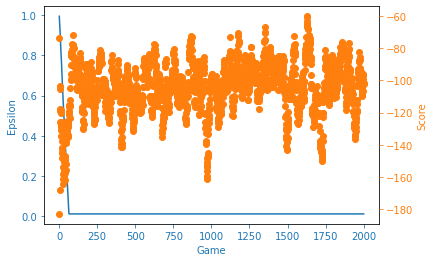

In [60]:
import gym
# from simple_dqn_torch_2020 import Agent

import numpy as np

env = gym.make('LunarLander-v4')
agent = Agent_lr(gamma=0.99, net= dqn_torch_v ,  epsilon=1.0, batch_size=64, n_actions=4, eps_end=0.01,
              input_dims=[8], lr=0.001,  eps_dec=2e-4, parameters= dqn_torch_v.parameters())
scores_1, eps_history = [], []
n_games = 2000

for i in range(n_games):
    score = 0
    done = False
    observation = env.reset()
    while not done:
      action = agent.choose_action(observation)
      observation_, reward, done, info = env.step(action)
      score += reward
      agent.store_transition(observation, action, reward, 
                              observation_, done)
      agent.learn()
      observation = observation_
    scores_1.append(score)
    eps_history.append(agent.epsilon)

    avg_score = np.mean(scores_1[-100:])

    print('episode ', i, 'score %.2f' % score,
            'average score %.2f' % avg_score,
            'epsilon %.2f' % agent.epsilon)
x_1 = [i+1 for i in range(n_games)]
filename = 'lunar_lander.png'
foo_2.plotLearning(x_1, scores_1, eps_history, filename)
    # x_np = np.array(x)[indices.astype(int)]
    # performance_metrics(x_np,scores)

    

In [ ]:
torch.save(agent.Q_eval.state_dict(), "/content/files/DQN_fine_tuned_files/tuned_baseline_extra_layer.zip" )

# Loading Model 2 the Noisey Model weights and exporting its weight to pytorch 

In [44]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# from YoutubeCodeRepository.ReinforcementLearning.DeepQLearning import simple_dqn_torch_2020

print(f"Is CUDA supported by this system?{torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")
import gym
print(f"ID of current CUDA device:{torch.cuda.current_device()}")



cuda = torch.device('cuda')  # Default CUDA device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
from stable_baselines3 import PPO
from stable_baselines3 import DQN

# model_path = "".format('dqn_lunar')

# model_path = log_dir_obstacle + "model_stable_avg_reward_300 (3).zip"
model_test = DQN.load("/content/Noisey_pretrain.zip")
print('loaded model')
# for key, value in model_test.get_parameters().items():
#     print(key, value.shape)

env = gym.make("LunarLander-v4").unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

paramshapes = model_test.get_parameters()


def copy_dqn_weights(baselines_model):
    torch_dqn = foo_1.DeepQNetwork(lr=0.001, n_actions=4, input_dims=[8], fc1_dims=256, fc2_dims=256)
    model_params = baselines_model.get_parameters()
    # Get only the policy parameters
    model_params = model_params['policy']
    policy_keys = [key for key in model_params.keys() if "pi" in key or "c" in key]
    policy_params = [model_params[key] for key in policy_keys]

    for (th_key, pytorch_param), key, policy_param in zip(torch_dqn.named_parameters(), policy_keys, policy_params):
        param = policy_param.copy()
        # Copy parameters from stable baselines model to pytorch model

        # Conv layer
        if len(param.shape) == 4:
            # https://gist.github.com/chirag1992m/4c1f2cb27d7c138a4dc76aeddfe940c2
            # Tensorflow 2D Convolutional layer: height * width * input channels * output channels
            # PyTorch 2D Convolutional layer: output channels * input channels * height * width
            param = np.transpose(param, (3, 2, 0, 1))

        # weight of fully connected layer
        if len(param.shape) == 2:
            param = param.T

        # bias
        if 'b' in key:
            param = param.squeeze()

        param = torch.from_numpy(param)
        pytorch_param.data.copy_(param.data.clone())

    return torch_dqn


dqn_torch_v_2 = copy_dqn_weights(model_test)
ct = 0

for child in dqn_torch_v_2.children():
    ct += 1
    if ct < 2:
        for param in child.parameters():
            print(param)
            print(ct)
            param.requires_grad = False

print(dqn_torch_v_2.parameters())
for param in dqn_torch_v_2.parameters():
  param.requires_grad = False
num_ftrs = 64  # 8 states we have for the polly to move 
num_classes = 4 # number of Actions at final layer 
# ResNet final fully connected layer
dqn_torch_v_2.fc = nn.Linear(num_ftrs, num_classes)
dqn_torch_v_2.to(device)
optimizer = torch.optim.Adam(dqn_torch_v_2.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()


# import gym


# # from YoutubeCodeRepository.ReinforcementLearning.DeepQLearning.utils import plotLearning

import numpy as np


def obs_to_torch(obs):
    # TF: NHWC
    # PyTorch: NCHW
    # https://discuss.pytorch.org/t/dimensions-of-an-input-image/19439
    # obs = np.transpose(obs, (0, 3, 1, 2))
    # # Normalize
    # obs = obs / 255.0
    obs = th.tensor(obs).float()
    obs = obs.to(device)
    return obs


env = gym.make('LunarLander-v4')

episode_reward = 0
done = False
obs = env.reset()
print(next(dqn_torch_v_2.parameters()).device)
while not done:
    action = th.argmax(dqn_torch_v_2(obs_to_torch(obs))).item()
    # action = env.action_space.sample()
    obs, reward, done, _ = env.step(action)
    episode_reward += reward

print(episode_reward)

cuda:0
Is CUDA supported by this system?True
CUDA version: 11.3
Name of current CUDA device:Tesla T4
ID of current CUDA device:0
cuda:0
loaded model
Parameter containing:
tensor([[-0.2699,  0.2215, -0.2805,  ...,  0.0768,  0.2879,  0.3533],
        [-0.0257, -0.2925, -0.0951,  ...,  0.1328,  0.1329, -0.3405],
        [ 0.3069,  0.2371, -0.0466,  ..., -0.2950,  0.3136, -0.1654],
        ...,
        [ 0.2993, -0.2371, -0.1341,  ...,  0.1764,  0.0587, -0.2268],
        [ 0.1419, -0.3017,  0.3421,  ...,  0.3309,  0.3151, -0.1235],
        [-0.2089, -0.1852, -0.3029,  ..., -0.1262, -0.1147,  0.2384]],
       device='cuda:0', requires_grad=True)
1
Parameter containing:
tensor([-0.0336,  0.2579,  0.3049, -0.3168, -0.0405,  0.0551,  0.0542,  0.2759,
         0.3215, -0.2255,  0.0892, -0.3376, -0.1296,  0.0549,  0.0086,  0.3483,
        -0.3105, -0.0151, -0.1516, -0.0812,  0.2399, -0.0945, -0.0795,  0.1701,
         0.0569, -0.1270,  0.1957,  0.0594,  0.0798,  0.3439,  0.2332,  0.2575,
       

<generator object Module.parameters at 0x7f360219cdd0>
episode  0 score -120.03 average score -120.03 epsilon 0.99


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/content/atchekegroup1lunarlanding/YoutubeCodeRepository/ReinforcementLearning/DeepQLearning/simple_dqn_torch_2020.py:71: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  state = T.tensor([observation]).to(self.Q_eval.device)


episode  1 score -73.01 average score -96.52 epsilon 0.97
episode  2 score -133.61 average score -108.89 epsilon 0.95
episode  3 score -312.13 average score -159.70 epsilon 0.93
episode  4 score -109.87 average score -149.73 epsilon 0.91
episode  5 score -397.07 average score -190.95 epsilon 0.88
episode  6 score -26.14 average score -167.41 epsilon 0.87
episode  7 score -398.08 average score -196.24 epsilon 0.84
episode  8 score -78.07 average score -183.11 epsilon 0.83
episode  9 score -159.68 average score -180.77 epsilon 0.81
episode  10 score -144.86 average score -177.50 epsilon 0.79
episode  11 score -87.22 average score -169.98 epsilon 0.77
episode  12 score -242.00 average score -175.52 epsilon 0.75
episode  13 score -189.07 average score -176.49 epsilon 0.73
episode  14 score -274.12 average score -183.00 epsilon 0.71
episode  15 score -207.65 average score -184.54 epsilon 0.68
episode  16 score -371.49 average score -195.54 epsilon 0.66
episode  17 score -227.37 average scor

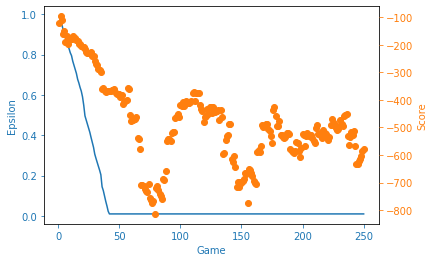

In [45]:
import gym
# from simple_dqn_torch_2020 import Agent

import numpy as np

env = gym.make('LunarLander-v4')
agent2 = Agent_lr(gamma=0.99, epsilon=0.99, batch_size=64, n_actions=4, eps_end=0.01,
              input_dims=[8], lr=0.001, eps_dec = 2e-4, parameters = dqn_torch_v_2.parameters())



scores_2, eps_history = [], []
n_games = 250

for i in range(n_games):
    score = 0
    done = False
    observation = env.reset()
    while not done:
      action = agent2.choose_action(observation)
      observation_, reward, done, info = env.step(action)
      score += reward
      agent2.store_transition(observation, action, reward, 
                              observation_, done)
      agent2.learn()
      observation = observation_
    scores_2.append(score)
    eps_history.append(agent2.epsilon)

    avg_score = np.mean(scores_2[-100:])

    print('episode ', i, 'score %.2f' % score,
            'average score %.2f' % avg_score,
            'epsilon %.2f' % agent2.epsilon)
x_2 = [i+1 for i in range(n_games)]
filename = 'lunar_lander.png'
foo_2.plotLearning(x_2, scores_2, eps_history, filename)
# x_np = np.array(x)[indices.astype(int)]
# performance_metrics(x_np,scores)

In [ ]:
# print(agent_2.Q_eval)
torch.save(agent2.Q_eval.state_dict(), "/content/files/DQN_fine_tuned_files/DQN_tuned_nosiey_added_layer.zip")

# Fine tuning the last hidden layer without adding any extra layer 

# Loading Model 1 the Baseline Model weights and exporting its weight to pytorch 

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# from YoutubeCodeRepository.ReinforcementLearning.DeepQLearning import simple_dqn_torch_2020

print(f"Is CUDA supported by this system?{torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device:{torch.cuda.current_device()}")

# print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")
import gym

cuda = torch.device('cuda')  # Default CUDA device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
from stable_baselines3 import PPO
from stable_baselines3 import DQN

# model_path = "".format('dqn_lunar')

# model_path = log_dir_obstacle + "model_stable_avg_reward_300 (3).zip"
model_test = DQN.load("/content/baseline_pretrained.zip")
print('loaded model')
# for key, value in model_test.get_parameters().items():
#     print(key, value.shape)

env = gym.make("LunarLander-v4").unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

paramshapes = model_test.get_parameters()


def copy_dqn_weights(baselines_model):
    torch_dqn = foo_1.DeepQNetwork(lr=0.001, n_actions=4, input_dims=[8], fc1_dims=256, fc2_dims=256)
    model_params = baselines_model.get_parameters()
    # Get only the policy parameters
    model_params = model_params['policy']
    policy_keys = [key for key in model_params.keys() if "pi" in key or "c" in key]
    policy_params = [model_params[key] for key in policy_keys]

    for (th_key, pytorch_param), key, policy_param in zip(torch_dqn.named_parameters(), policy_keys, policy_params):
        param = policy_param.copy()
        # Copy parameters from stable baselines model to pytorch model

        # Conv layer
        if len(param.shape) == 4:
            # https://gist.github.com/chirag1992m/4c1f2cb27d7c138a4dc76aeddfe940c2
            # Tensorflow 2D Convolutional layer: height * width * input channels * output channels
            # PyTorch 2D Convolutional layer: output channels * input channels * height * width
            param = np.transpose(param, (3, 2, 0, 1))

        # weight of fully connected layer
        if len(param.shape) == 2:
            param = param.T

        # bias
        if 'b' in key:
            param = param.squeeze()

        param = torch.from_numpy(param)
        pytorch_param.data.copy_(param.data.clone())

    return torch_dqn


dqn_torch_v = copy_dqn_weights(model_test)
ct = 0

print(dqn_torch_v.parameters())

for child in dqn_torch_v.children():
    ct += 1
    if ct < 2:
        for param in child.parameters():
            # print(param)
            # print(ct)
            param.requires_grad = False
            # print("the param")
            # print(param.requires_grad)

for param in child.parameters():
  # print(param)
  # print(ct)
  # param.requires_grad = False
  print("the param")
  print(param.requires_grad)

print(dqn_torch_v.parameters())




for param in dqn_torch_v.parameters():
  param.requires_grad = False
  # print(1)
  # print(param)
# num_ftrs = 64  # 8 states we have for the polly to move 
# num_classes = 4 # number of Actions at final layer 
# # ResNet final fully connected layer
# dqn_torch_v.fc = nn.Linear(num_ftrs, num_classes)
dqn_torch_v.to(device)
optimizer = torch.optim.Adam(dqn_torch_v.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()



# import gym


# # from YoutubeCodeRepository.ReinforcementLearning.DeepQLearning.utils import plotLearning

# import numpy as np


# def obs_to_torch(obs):
#     # TF: NHWC
#     # PyTorch: NCHW
#     # https://discuss.pytorch.org/t/dimensions-of-an-input-image/19439
#     # obs = np.transpose(obs, (0, 3, 1, 2))
#     # # Normalize
#     # obs = obs / 255.0
#     obs = th.tensor(obs).float()
#     obs = obs.to(device)
#     return obs


# env = gym.make('LunarLander-v4')

# episode_reward = 0
# done = False
# obs = env.reset()
# print(next(dqn_torch_v.parameters()).device)
# while not done:
#     action = th.argmax(dqn_torch_v(obs_to_torch(obs))).item()
#     # action = env.action_space.sample()
#     obs, reward, done, _ = env.step(action)
#     episode_reward += reward

# print(episode_reward)

cuda:0
Is CUDA supported by this system?True
CUDA version: 11.3
ID of current CUDA device:0
cuda:0
loaded model
<generator object Module.parameters at 0x7f3634f40ed0>
<generator object Module.parameters at 0x7f3634f40ed0>


<generator object Module.parameters at 0x7f3634406f50>
episode  0 score -198.61 average score -198.61 epsilon 1.00


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


episode  1 score -100.27 average score -149.44 epsilon 0.98
episode  2 score -87.64 average score -128.84 epsilon 0.96
episode  3 score -489.30 average score -218.95 epsilon 0.94
episode  4 score -518.85 average score -278.93 epsilon 0.92
episode  5 score -60.07 average score -242.46 epsilon 0.89
episode  6 score 11.43 average score -206.19 epsilon 0.88
episode  7 score -340.27 average score -222.95 epsilon 0.87
episode  8 score -144.52 average score -214.23 epsilon 0.84
episode  9 score -49.24 average score -197.73 epsilon 0.82
episode  10 score -176.45 average score -195.80 epsilon 0.79
episode  11 score -129.76 average score -190.30 epsilon 0.76
episode  12 score -285.78 average score -197.64 epsilon 0.74
episode  13 score -157.63 average score -194.78 epsilon 0.71
episode  14 score -484.53 average score -214.10 epsilon 0.69
episode  15 score -302.67 average score -219.63 epsilon 0.68
episode  16 score -320.88 average score -225.59 epsilon 0.66
episode  17 score -417.47 average scor

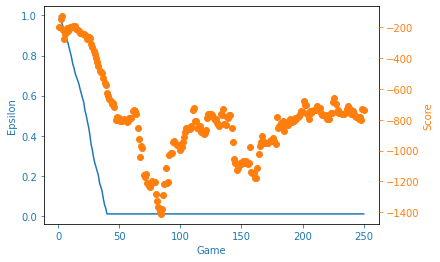

In [47]:
import gym
# from simple_dqn_torch_2020 import Agent

import numpy as np

env = gym.make('LunarLander-v4')
agent = Agent_lr(gamma=0.99, epsilon=1.0, batch_size=64, n_actions=4, eps_end=0.01,
              input_dims=[8], lr=0.001,  eps_dec=2e-4, parameters = dqn_torch_v.parameters())
scores_1, eps_history = [], []
n_games = 250

for i in range(n_games):
    score = 0
    done = False
    observation = env.reset()
    while not done:
      action = agent.choose_action(observation)
      observation_, reward, done, info = env.step(action)
      score += reward
      agent.store_transition(observation, action, reward, 
                              observation_, done)
      agent.learn()
      observation = observation_
    scores_1.append(score)
    eps_history.append(agent.epsilon)

    avg_score = np.mean(scores_1[-100:])

    print('episode ', i, 'score %.2f' % score,
            'average score %.2f' % avg_score,
            'epsilon %.2f' % agent.epsilon)
x_1 = [i+1 for i in range(n_games)]
filename = 'lunar_lander.png'
foo_2.plotLearning(x_1, scores_1, eps_history, filename)
    # x_np = np.array(x)[indices.astype(int)]
    # performance_metrics(x_np,scores)

    

In [ ]:
torch.save(agent.Q_eval.state_dict(), "/content/files/DQN_fine_tuned_files/tuned_baseline_no_extra_layer.zip" )

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# from YoutubeCodeRepository.ReinforcementLearning.DeepQLearning import simple_dqn_torch_2020

print(f"Is CUDA supported by this system?{torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")
import gym
print(f"ID of current CUDA device:{torch.cuda.current_device()}")



cuda = torch.device('cuda')  # Default CUDA device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
from stable_baselines3 import PPO
from stable_baselines3 import DQN

# model_path = "".format('dqn_lunar')

# model_path = log_dir_obstacle + "model_stable_avg_reward_300 (3).zip"
model_test = DQN.load("/content/Noisey_pretrain.zip")
print('loaded model')
# for key, value in model_test.get_parameters().items():
#     print(key, value.shape)

env = gym.make("LunarLander-v4").unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

paramshapes = model_test.get_parameters()


def copy_dqn_weights(baselines_model):
    torch_dqn = foo_1.DeepQNetwork(lr=0.001, n_actions=4, input_dims=[8], fc1_dims=256, fc2_dims=256)
    model_params = baselines_model.get_parameters()
    # Get only the policy parameters
    model_params = model_params['policy']
    policy_keys = [key for key in model_params.keys() if "pi" in key or "c" in key]
    policy_params = [model_params[key] for key in policy_keys]

    for (th_key, pytorch_param), key, policy_param in zip(torch_dqn.named_parameters(), policy_keys, policy_params):
        param = policy_param.copy()
        # Copy parameters from stable baselines model to pytorch model

        # Conv layer
        if len(param.shape) == 4:
            # https://gist.github.com/chirag1992m/4c1f2cb27d7c138a4dc76aeddfe940c2
            # Tensorflow 2D Convolutional layer: height * width * input channels * output channels
            # PyTorch 2D Convolutional layer: output channels * input channels * height * width
            param = np.transpose(param, (3, 2, 0, 1))

        # weight of fully connected layer
        if len(param.shape) == 2:
            param = param.T

        # bias
        if 'b' in key:
            param = param.squeeze()

        param = torch.from_numpy(param)
        pytorch_param.data.copy_(param.data.clone())

    return torch_dqn


dqn_torch_v_2 = copy_dqn_weights(model_test)
ct = 0

for child in dqn_torch_v_2.children():
    ct += 1
    if ct < 2:
        for param in child.parameters():
            print(param)
            print(ct)
            param.requires_grad = False

print(dqn_torch_v_2.parameters())
for param in dqn_torch_v_2.parameters():
  param.requires_grad = False
# num_ftrs = 64  # 8 states we have for the polly to move 
# num_classes = 4 # number of Actions at final layer 
# ResNet final fully connected layer
# dqn_torch_v_2.fc = nn.Linear(num_ftrs, num_classes)
dqn_torch_v_2.to(device)
optimizer = torch.optim.Adam(dqn_torch_v_2.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()


# import gym


# # from YoutubeCodeRepository.ReinforcementLearning.DeepQLearning.utils import plotLearning

import numpy as np


def obs_to_torch(obs):
    # TF: NHWC
    # PyTorch: NCHW
    # https://discuss.pytorch.org/t/dimensions-of-an-input-image/19439
    # obs = np.transpose(obs, (0, 3, 1, 2))
    # # Normalize
    # obs = obs / 255.0
    obs = th.tensor(obs).float()
    obs = obs.to(device)
    return obs


env = gym.make('LunarLander-v4')

episode_reward = 0
done = False
obs = env.reset()
print(next(dqn_torch_v_2.parameters()).device)
while not done:
    action = th.argmax(dqn_torch_v_2(obs_to_torch(obs))).item()
    # action = env.action_space.sample()
    obs, reward, done, _ = env.step(action)
    episode_reward += reward

print(episode_reward)

cuda:0
Is CUDA supported by this system?True
CUDA version: 11.3
Name of current CUDA device:Tesla T4
ID of current CUDA device:0
cuda:0
loaded model
Parameter containing:
tensor([[-0.2699,  0.2215, -0.2805,  ...,  0.0768,  0.2879,  0.3533],
        [-0.0257, -0.2925, -0.0951,  ...,  0.1328,  0.1329, -0.3405],
        [ 0.3069,  0.2371, -0.0466,  ..., -0.2950,  0.3136, -0.1654],
        ...,
        [ 0.2993, -0.2371, -0.1341,  ...,  0.1764,  0.0587, -0.2268],
        [ 0.1419, -0.3017,  0.3421,  ...,  0.3309,  0.3151, -0.1235],
        [-0.2089, -0.1852, -0.3029,  ..., -0.1262, -0.1147,  0.2384]],
       device='cuda:0', requires_grad=True)
1
Parameter containing:
tensor([-0.0336,  0.2579,  0.3049, -0.3168, -0.0405,  0.0551,  0.0542,  0.2759,
         0.3215, -0.2255,  0.0892, -0.3376, -0.1296,  0.0549,  0.0086,  0.3483,
        -0.3105, -0.0151, -0.1516, -0.0812,  0.2399, -0.0945, -0.0795,  0.1701,
         0.0569, -0.1270,  0.1957,  0.0594,  0.0798,  0.3439,  0.2332,  0.2575,
       

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


<generator object Module.parameters at 0x7f96e83c6d50>
episode  0 score -242.63 average score -242.63 epsilon 0.98
episode  1 score -94.87 average score -168.75 epsilon 0.97
episode  2 score -25.59 average score -121.03 epsilon 0.95
episode  3 score -81.04 average score -111.03 epsilon 0.93
episode  4 score -8.69 average score -90.57 epsilon 0.92
episode  5 score -108.38 average score -93.53 epsilon 0.91
episode  6 score -75.85 average score -91.01 epsilon 0.89
episode  7 score -303.04 average score -117.51 epsilon 0.87
episode  8 score -106.80 average score -116.32 epsilon 0.86
episode  9 score -53.66 average score -110.05 epsilon 0.84
episode  10 score -504.63 average score -145.93 epsilon 0.81
episode  11 score -419.55 average score -168.73 epsilon 0.80
episode  12 score -96.77 average score -163.19 epsilon 0.78
episode  13 score -151.60 average score -162.36 epsilon 0.76
episode  14 score -247.41 average score -168.03 epsilon 0.75
episode  15 score -454.56 average score -185.94 eps

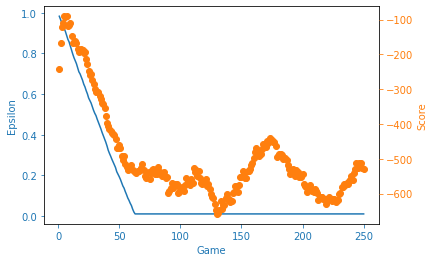

In [ ]:
import gym
# from simple_dqn_torch_2020 import Agent

import numpy as np

env = gym.make('LunarLander-v4')
agent2 = Agent_lr(gamma=0.99, epsilon=0.99, batch_size=64, n_actions=4, eps_end=0.01,
              input_dims=[8], lr=0.001, eps_dec = 2e-4, parameters = dqn_torch_v_2.parameters())

print(agent2.Q_eval.parameters)



scores_2, eps_history = [], []
n_games = 250

for i in range(n_games):
    score = 0
    done = False
    observation = env.reset()
    while not done:
      action = agent2.choose_action(observation)
      observation_, reward, done, info = env.step(action)
      score += reward
      agent2.store_transition(observation, action, reward, 
                              observation_, done)
      agent2.learn()
      observation = observation_
    scores_2.append(score)
    eps_history.append(agent2.epsilon)

    avg_score = np.mean(scores_2[-100:])

    print('episode ', i, 'score %.2f' % score,
            'average score %.2f' % avg_score,
            'epsilon %.2f' % agent2.epsilon)
x_2 = [i+1 for i in range(n_games)]
filename = 'lunar_lander.png'
foo_2.plotLearning(x_2, scores_2, eps_history, filename)
# x_np = np.array(x)[indices.astype(int)]
# performance_metrics(x_np,scores)

In [ ]:
# print(agent_2.Q_eval)
torch.save(agent2.Q_eval.state_dict(), "/content/files/DQN_fine_tuned_files/DQN_tuned_nosiey_no_layer.zip")

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from numpy import random
import pandas as pd

In [ ]:



all_model_rewards = {
    "agent": {
        "x": np.array(x_1),
        "y": np.array(scores_1),
    },
    "agent2": {
        "x": np.array(x_2),
        "y": np.array(scores_2),
    }
}

# def generate_sample_models(number_of_models):
#     '''
#     This is function which generates sample models.
#     '''
#     for n in range(number_of_models):
#         reward_dict = {}
#         model_version_num = 'DQN' + str(n)
#         x = np.linspace(1,100,100) ## these are the timesteps
#         y = random.rand(100)
#         reward_dict = {'x': x, 'y' : y, 'comment': 'here comes the comment'}
#         all_model_rewards[model_version_num] = reward_dict

# generate_sample_models(all_model_rewards)

In [ ]:
model_evs = {}

def model_evaluations(all_model_rewards): 
    
    '''
    This is a function performing model evaluations. 
    
    Input: a dict in the following format:
    {'DQN5': {'x': array([  1.,   2.,   3.,  ....]),
             'y': array([0.47025739, 0.5788533 , 0.72454499,...]),
             'comment': 'comment for the model'}}
             
             
             
    The function performing the following metrics:
    
    
    1. Max reward. 
    2. Jumpstart: The initial performance of an agent in a target task may be improved by transfer from a source task.
    3. Asymptotic Performance: The final learned performance of an agent in the target task may be improved via transfer.
    4. Total Reward: The total reward accumulated by an agent (i.e., the area under the learning curve) may be improved if it uses transfer, compared to learning without transfer.
    '''
    
    
    
    
    max_reward = {}
    jumpstart = {}
    total_reward = {}
    asymptotic_performance = {}
    
    for m in all_model_rewards.keys():
        
        max_reward[m] = all_model_rewards[m]['y'].max()
        
        ####################################
        ######### NB! Here you can define on how long section do you want to evaluate jumpstart. 
        ######### It should start from the beginning of the array. 
        ####################################
        jumpstart[m] =  all_model_rewards[m]['y'][:10].mean() 
        
        total_reward[m] =  all_model_rewards[m]['y'].sum()
        
        ####################################
        ######### NB! Here you can define on how long section do you want to evaluate asymptotic performance. 
        ######### It end at the end of the session.
        ####################################
        asymptotic_performance[m] =  all_model_rewards[m]['y'][-10:].sum()

        
        
    ## Add the metrics to the final evaluation metric 
    
    model_evs['max_reward'] = max_reward
    model_evs['jumpstart'] = jumpstart
    model_evs['total_reward'] = total_reward
    model_evs['asymptotic_performance'] = asymptotic_performance

    # return model_evs

    
    
    
model_evaluations(all_model_rewards)  
results = pd.DataFrame(model_evs)
results.style.highlight_max(color = 'lightgreen', axis = 0)

,max_reward,jumpstart,total_reward,asymptotic_performance
agent,187.168604,-204.372757,-21338.272950,564.390009
agent2,-1.998443,-133.902764,-1436.851850,-1093.739594


In [ ]:
# peformance matrix

model_evaluations()

NameError: ignored

In [ ]:
def transfer_ratio(transfer_learner, scratch_model): 

    ''' Transfer Ratio: The ratio of the total reward accumulated by the transfer learner and the total reward accumulated by the non-transfer learner.'''

    transfer_ratio = (transfer_learner['y']/scratch_model['y']).sum()
    return (transfer_ratio)




def time_to_threshold(transfer_learner, scratch_model):
    
    
    '''
    Time to Threshold: The learning time needed by the agent to achieve a pre-specified perfor- mance level may be reduced via knowledge transfer.


    This function returns the first timestep of the transfer_learning model when it reaches the scratch
    model's maximum value. The threshold could be changed to 
        - any fixed number
        - ratio of the scratch model's maximum reward
        - the average of the final performance (averaged over the last n timesteps) of the scratch model. 
    '''
    
    threshold = scratch_model['y'].max()
    threshold_index = np.where(transfer_learner['y'] >= threshold)[0][0]
    
    
    return 'Transfer learner\'s performance reaches the threashold (scratch model\'s max performance) at timestap {}. Threshold is {}'.format(threshold_index, threshold)
    
transfer_ratio( all_model_rewards["agent2"], all_model_rewards["agent"])  

time_to_threshold(all_model_rewards["agent2"], all_model_rewards["agent"])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def jumpstart(y):
    return (y[0])


def asymptotic_performance(y, rolling_avg=1):
    asymptotic_performance = np.mean(y[-rolling_avg:])
    return asymptotic_performance


def total_reward_fnc(y):
    return np.sum(y)


def transfer_ratio(y_transfer, y_reference, total_reward):
    transfer_ratio = total_reward(y_transfer) / total_reward(y_reference)
    return transfer_ratio


def time_to_threshold(x, y, threshold=250):
    return x[np.argmax(y > threshold)]


def max_reward_fnc(y):
    return np.max(y), np.argmax(y)


def performance_metrics(x, y, rolling_avg=10, threshold=275, plot=True):
    '''
    TODO: write plots functions
    '''

    max_reward, idx_training_max = max_reward_fnc(y)
    total_reward = total_reward_fnc(y)
    n_timesteps = max(x)
    reward_per_timestep = total_reward / n_timesteps
    asymptote = asymptotic_performance(y, rolling_avg=rolling_avg)
    std_asymptote = np.std(y[-rolling_avg:])
    asymptote_after_max = asymptotic_performance(y, rolling_avg=n_timesteps - idx_training_max)
    std_asymptote_after_max = np.std(y[-(n_timesteps - idx_training_max):])
    time_threshold = time_to_threshold(x, y, threshold=threshold)
    threshold_80 = 0.80 * threshold
    time_threshold_80_of_max = time_to_threshold(x, y, threshold=threshold_80)
    print(0.80 * max_reward)

    print(f" Max reward: {max_reward} \
        \n Time steps to max reward: {idx_training_max}/{n_timesteps} ({idx_training_max * 100 / n_timesteps:.2f}% of training period) \
        \n Total reward: {total_reward:.2f} \
        \n Reward per timestep: {reward_per_timestep:.2f} \
        \n Asymptotic performance (last {rolling_avg} timesteps): {asymptote:.2f} ±{std_asymptote:.2f} ({asymptote * 100 / max_reward:.2f}% of max reward) \
        \n Asymptotic performance after max: {asymptote_after_max:.2f} ±{std_asymptote_after_max:.2f} ({asymptote_after_max * 100 / max_reward:.2f}% of max reward) \
        \n Time to threshold(={threshold}): {time_threshold}/{n_timesteps} ({time_threshold * 100 / n_timesteps:.2f}% of training period) \
        \n Time to threshold(80% of max={threshold_80}): {time_threshold_80_of_max}/{n_timesteps} ({time_threshold_80_of_max * 100 / n_timesteps:.2f}% of training period)" \
          )

    if plot == True:
        sns.scatterplot(x=x, y=y, color='green')
        plt.title('Reward Over Timesteps 2')
        plt.xlabel('Episode Index')
        plt.ylabel('Reward')
        plt.show()

        # sns.barplot(data=[asymptote])
        # plt.show()
        numpy_data = ([threshold, time_threshold_80_of_max])

        plt.bar([0, 1], [time_threshold, time_threshold_80_of_max], color=['green', 'blue'])
        plt.xticks([0, 1], labels=['Time to Max Threshold', 'Time to 80% max threshold'])
        plt.title('Threshold Time')
        plt.ylabel('Episode Number')
        plt.show()

# Adding Double DQN for Stability test

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from collections import namedtuple, deque
from tqdm import tqdm
%matplotlib inline
import gym
from datetime import datetime
import pandas as pd  
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import namedtuple, deque
import itertools

In [21]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        
#         print('state:', state.shape)
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [73]:

class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims,
                 n_actions, parameters):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
        # self.parameters = parameters;

        # print(self.parameters)
        # self.optimizer = optim.Adam(self.parameters, lr=lr)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, state_size, action_size, buffer_size, batch_size, priority=False):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer (chosen as multiple of num agents)
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.states = torch.zeros((buffer_size,)+(state_size,)).to(device)
        self.next_states = torch.zeros((buffer_size,)+(state_size,)).to(device)
        self.actions = torch.zeros(buffer_size,1, dtype=torch.long).to(device)
        self.rewards = torch.zeros(buffer_size, 1, dtype=torch.float).to(device)
        self.dones = torch.zeros(buffer_size, 1, dtype=torch.float).to(device)
        self.e = np.zeros((buffer_size, 1), dtype=np.float)
        
        self.priority = priority

        self.ptr = 0
        self.n = 0
        self.buffer_size = buffer_size
        self.batch_size = batch_size
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        self.states[self.ptr] = torch.from_numpy(state).to(device)
        self.next_states[self.ptr] = torch.from_numpy(next_state).to(device)
        
        self.actions[self.ptr] = torch.from_numpy(np.asarray(action)).to(device)
        self.rewards[self.ptr] = torch.from_numpy(np.asarray(reward)).to(device)
        self.dones[self.ptr] = done
#         self.actions[self.ptr] = action
#         self.rewards[self.ptr] = reward
#         self.dones[self.ptr] = done
        
        self.ptr += 1
        if self.ptr >= self.buffer_size:
            self.ptr = 0
            self.n = self.buffer_size

    def sample(self, get_all=False):
        """Randomly sample a batch of experiences from memory."""
        n = len(self)
        if get_all:
            return self.states[:n], self.actions[:n], self.rewards[:n], self.next_states[:n], self.dones[:n]
        # else:
        if self.priority:
            idx = np.random.choice(n, self.batch_size, replace=False, p=self.e)
        else:
            idx = np.random.choice(n, self.batch_size, replace=False)
        
        states = self.states[idx]
        next_states = self.next_states[idx]
        actions = self.actions[idx]
        rewards = self.rewards[idx]
        dones = self.dones[idx]
        
        return (states, actions, rewards, next_states, dones), idx
      
    def update_error(self, e, idx=None):
        e = torch.abs(e.detach())
        e = e / e.sum()
        if idx is not None:
            self.e[idx] = e.cpu().numpy()
        else:
            self.e[:len(self)] = e.cpu().numpy()
        
    def __len__(self):
        if self.n == 0:
            return self.ptr
        else:
            return self.n

In [23]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

In [78]:
class DDQNAgent():
    """Interacts with and learns from the environment."""

    def __init__(self,net, parameters, state_size, action_size, seed=42, ddqn=True, priority=False, ):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.ddqn = ddqn
        self.parameters = parameters

        # Q-Network
#         self.qnetwork_local = model(state_size[0], action_size, seed).to(device)
#         self.qnetwork_target = model(state_size[0], action_size, seed).to(device)
        
        # self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_local = net;
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(state_size, (action_size,), BUFFER_SIZE, BATCH_SIZE)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences, idx = self.memory.sample()
                e = self.learn(experiences)
                self.memory.update_error(e, idx)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
          
    def update_error(self):
        states, actions, rewards, next_states, dones = self.memory.sample(get_all=True)
        with torch.no_grad():
            if self.ddqn:
                old_val = self.qnetwork_local(states).gather(-1, actions)
                actions = self.qnetwork_local(next_states).argmax(-1, keepdim=True)
                maxQ = self.qnetwork_target(next_states).gather(-1, actions)
                target = rewards+GAMMA*maxQ*(1-dones)
            else: # Normal DQN
                maxQ = self.qnetwork_target(next_states).max(-1, keepdim=True)[0]
                target = rewards+GAMMA*maxQ*(1-dones)
                old_val = self.qnetwork_local(states).gather(-1, actions)
            e = old_val - target
            self.memory.update_error(e)

    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        ## compute and minimize the loss
        self.optimizer.zero_grad()
        if self.ddqn:
            old_val = self.qnetwork_local(states).gather(-1, actions)
            with torch.no_grad():
                next_actions = self.qnetwork_local(next_states).argmax(-1, keepdim=True)
                maxQ = self.qnetwork_target(next_states).gather(-1, next_actions)
                target = rewards+GAMMA*maxQ*(1-dones)
        else: # Normal DQN
            with torch.no_grad():
                maxQ = self.qnetwork_target(next_states).max(-1, keepdim=True)[0]
                target = rewards+GAMMA*maxQ*(1-dones)
            old_val = self.qnetwork_local(states).gather(-1, actions)   
        
        loss = F.mse_loss(old_val, target)
        loss.requires_grad = True;
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU) 
        
        return old_val - target


    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [28]:
envs=['LunarLander-v4']
ls=[[True,'DQN'],[True,'DDQN']]
n_episodes=500
max_t=1000
eps_start=1.0
eps_end=0.01
eps_decay=0.995

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


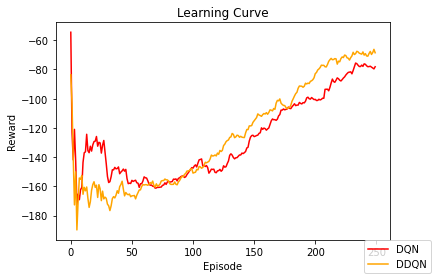

In [ ]:

fig=plt.figure()   

reward='./'+'result'
df=pd.DataFrame({'DQN':res[0],'DDQN':res[1]})
df.to_csv(reward+'.csv')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(df['DQN'], 'r', label='DQN')

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(df['DDQN'], 'orange',label='DDQN')

# plt.xlabel("Episode")
# plt.ylabel("Reward")
# plt.plot(df['Priority'],'b',label='PER')

plt.title('Learning Curve')

# agent.save('Model_dqn.h5')
fig.legend(loc='lower right')
fig.savefig(reward+'.png', dpi=100)
fig.show()

# Making the DDQN and DQN for transfer learning the last hidden layer only for the weights might improve the peformance

In [74]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# from YoutubeCodeRepository.ReinforcementLearning.DeepQLearning import simple_dqn_torch_2020

print(f"Is CUDA supported by this system?{torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")
import gym
print(f"ID of current CUDA device:{torch.cuda.current_device()}")



cuda = torch.device('cuda')  # Default CUDA device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
from stable_baselines3 import PPO
from stable_baselines3 import DQN

# model_path = "".format('dqn_lunar')

# model_path = log_dir_obstacle + "model_stable_avg_reward_300 (3).zip"
model_test = DQN.load("/content/Noisey_pretrain.zip")
print('loaded model')
# for key, value in model_test.get_parameters().items():
#     print(key, value.shape)

env = gym.make("LunarLander-v4").unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

paramshapes = model_test.get_parameters()


def copy_dqn_weights(baselines_model):
    torch_dqn = foo_1.DeepQNetwork(lr=0.001, n_actions=4, input_dims=[8], fc1_dims=256, fc2_dims=256)
    model_params = baselines_model.get_parameters()
    # Get only the policy parameters
    model_params = model_params['policy']
    policy_keys = [key for key in model_params.keys() if "pi" in key or "c" in key]
    policy_params = [model_params[key] for key in policy_keys]

    for (th_key, pytorch_param), key, policy_param in zip(torch_dqn.named_parameters(), policy_keys, policy_params):
        param = policy_param.copy()
        # Copy parameters from stable baselines model to pytorch model

        # Conv layer
        if len(param.shape) == 4:
            # https://gist.github.com/chirag1992m/4c1f2cb27d7c138a4dc76aeddfe940c2
            # Tensorflow 2D Convolutional layer: height * width * input channels * output channels
            # PyTorch 2D Convolutional layer: output channels * input channels * height * width
            param = np.transpose(param, (3, 2, 0, 1))

        # weight of fully connected layer
        if len(param.shape) == 2:
            param = param.T

        # bias
        if 'b' in key:
            param = param.squeeze()

        param = torch.from_numpy(param)
        pytorch_param.data.copy_(param.data.clone())

    return torch_dqn


dqn_torch_v_2 = copy_dqn_weights(model_test)
ct = 0

for child in dqn_torch_v_2.children():
    ct += 1
    if ct < 2:
        for param in child.parameters():
            print(param)
            print(ct)
            param.requires_grad = False

print(dqn_torch_v_2.parameters())
for param in dqn_torch_v_2.parameters():
  param.requires_grad = False
# num_ftrs = 64  # 8 states we have for the polly to move 
# num_classes = 4 # number of Actions at final layer 
# ResNet final fully connected layer
# dqn_torch_v_2.fc = nn.Linear(num_ftrs, num_classes)
dqn_torch_v_2.to(device)
optimizer = torch.optim.Adam(dqn_torch_v_2.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()



cuda:0
Is CUDA supported by this system?True
CUDA version: 11.3
Name of current CUDA device:Tesla T4
ID of current CUDA device:0
cuda:0
loaded model
Parameter containing:
tensor([[-0.2699,  0.2215, -0.2805,  ...,  0.0768,  0.2879,  0.3533],
        [-0.0257, -0.2925, -0.0951,  ...,  0.1328,  0.1329, -0.3405],
        [ 0.3069,  0.2371, -0.0466,  ..., -0.2950,  0.3136, -0.1654],
        ...,
        [ 0.2993, -0.2371, -0.1341,  ...,  0.1764,  0.0587, -0.2268],
        [ 0.1419, -0.3017,  0.3421,  ...,  0.3309,  0.3151, -0.1235],
        [-0.2089, -0.1852, -0.3029,  ..., -0.1262, -0.1147,  0.2384]],
       device='cuda:0', requires_grad=True)
1
Parameter containing:
tensor([-0.0336,  0.2579,  0.3049, -0.3168, -0.0405,  0.0551,  0.0542,  0.2759,
         0.3215, -0.2255,  0.0892, -0.3376, -0.1296,  0.0549,  0.0086,  0.3483,
        -0.3105, -0.0151, -0.1516, -0.0812,  0.2399, -0.0945, -0.0795,  0.1701,
         0.0569, -0.1270,  0.1957,  0.0594,  0.0798,  0.3439,  0.2332,  0.2575,
       

In [75]:
envs=['LunarLander-v4']
ls=[[True,'DQN'],[True,'DDQN']]
n_episodes=500
max_t=1000
eps_start=1.0
eps_end=0.01
eps_decay=0.995

In [80]:
i = 0;

env = gym.make(envs[i])
# env.seed(0)
res=[]
for j in ls:
    
    rewards = []
    aver_reward = []
    aver = deque(maxlen=100)
    state_size = env.observation_space.shape[0]
    action_size=env.action_space.n
    agent = DDQNAgent(dqn_torch_v_2,dqn_torch_v_2.parameters() ,state_size ,action_size, 1, ddqn=j[0], priority=j[1])
    eps = eps_start                    # initialize epsilon
    for i_episode in tqdm(range(1, n_episodes+1)):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 

        aver.append(score)     
        aver_reward.append(np.mean(aver))
        rewards.append(score)
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
    # reward="model/0"+"_"+j[0]+"_"+str(n_episodes)+"_"+str(datetime.now().strftime("%Y%m%d%H%M%S"))
    torch.save(agent.qnetwork_local.state_dict(),'rewards.pt')
    res.append(aver_reward)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  0%|          | 0/500 [00:00<?, ?it/s]


RuntimeError: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


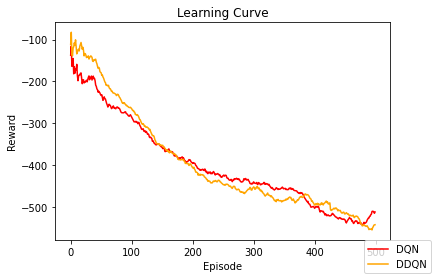

In [43]:

fig=plt.figure()   

reward='./'+'result'
df=pd.DataFrame({'DQN':res[0],'DDQN':res[1]})
df.to_csv(reward+'.csv')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(df['DQN'], 'r', label='DQN')

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(df['DDQN'], 'orange',label='DDQN')

# plt.xlabel("Episode")
# plt.ylabel("Reward")
# plt.plot(df['Priority'],'b',label='PER')

plt.title('Learning Curve')

# agent.save('Model_dqn.h5')
fig.legend(loc='lower right')
fig.savefig(reward+'.png', dpi=100)
fig.show()

In [ ]:
# import gym
# # from simple_dqn_torch_2020 import Agent

# import numpy as np

# env = gym.make('LunarLander-v4')
# agent2 = Agent_lr(gamma=0.99, epsilon=0.99, batch_size=64, n_actions=4, eps_end=0.01,
#               input_dims=[8], lr=0.001, eps_dec = 2e-4)



# scores_2, eps_history = [], []
# n_games = 250

# for i in range(n_games):
#     score = 0
#     done = False
#     observation = env.reset()
#     while not done:
#       action = agent2.choose_action(observation)
#       observation_, reward, done, info = env.step(action)
#       score += reward
#       agent2.store_transition(observation, action, reward, 
#                               observation_, done)
#       agent2.learn()
#       observation = observation_
#     scores_2.append(score)
#     eps_history.append(agent2.epsilon)

#     avg_score = np.mean(scores_2[-100:])

#     print('episode ', i, 'score %.2f' % score,
#             'average score %.2f' % avg_score,
#             'epsilon %.2f' % agent2.epsilon)
# x_2 = [i+1 for i in range(n_games)]
# filename = 'lunar_lander.png'
# foo_2.plotLearning(x_2, scores_2, eps_history, filename)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


episode  0 score -276.90 average score -276.90 epsilon 0.98
episode  1 score -66.21 average score -171.56 epsilon 0.97
episode  2 score -127.14 average score -156.75 epsilon 0.94
episode  3 score -305.33 average score -193.90 epsilon 0.92
episode  4 score -71.25 average score -169.37 epsilon 0.90
episode  5 score -390.62 average score -206.24 epsilon 0.89
episode  6 score -2.00 average score -177.07 epsilon 0.86
episode  7 score -69.44 average score -163.61 epsilon 0.84
episode  8 score -20.45 average score -147.70 epsilon 0.82
episode  9 score -9.69 average score -133.90 epsilon 0.80
episode  10 score -52.04 average score -126.46 epsilon 0.78
episode  11 score -45.78 average score -119.74 epsilon 0.77


KeyboardInterrupt: ignored

In [ ]:
# import torch
# from torch import nn
# from torch.utils.data import TensorDataset, DataLoader
# # from Model import Model
# import gym
# from collections import deque
# import random

# # Parameters
# use_cuda = True
# episode_limit = 100
# target_update_delay = 2  # update target net every target_update_delay episodes
# test_delay = 10
# learning_rate = 1e-4
# epsilon = 1  # initial epsilon
# min_epsilon = 0.1
# epsilon_decay = 0.9 / 2.5e3
# gamma = 0.99
# memory_len = 10000

# # env = gym.make('CartPole-v1')
# # n_features = len(env.observation_space.high)
# # n_actions = env.action_space.n

# n_features = 8
# n_actions = 4
# memory = deque(maxlen=memory_len)
# # each memory entry is in form: (state, action, env_reward, next_state)
# device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
# criterion = nn.MSELoss()
# policy_net = foo_1.DeepQNetwork(input_dims=[8], n_actions=4, lr = learning_rate, fc1_dims = 256, fc2_dims = 256 ).to(device)
# target_net = foo_1.DeepQNetwork(input_dims=[8], n_actions =4, lr = learning_rate, fc1_dims = 256, fc2_dims = 256).to(device)
# target_net.load_state_dict(policy_net.state_dict())
# target_net.eval()


# def get_states_tensor(sample, states_idx):
#     sample_len = len(sample)
#     states_tensor = torch.empty((sample_len, n_features), dtype=torch.float32, requires_grad=False)

#     features_range = range(n_features)
#     for i in range(sample_len):
#         for j in features_range:
#             states_tensor[i, j] = sample[i][states_idx][j].item()

#     return states_tensor


# def normalize_state(state):
#     state[0] /= 2.5
#     state[1] /= 2.5
#     state[2] /= 0.3
#     state[3] /= 0.3


# def state_reward(state, env_reward):
#     return env_reward - (abs(state[0]) + abs(state[2])) / 2.5


# def get_action(state, e=min_epsilon):
#     if random.random() < e:
#         # explore
#         action = random.randrange(0, n_actions)
#     else:
#         state = torch.tensor(state, dtype=torch.float32, device=device)
#         action = policy_net(state).argmax().item()

#     return action


# def fit(model, inputs, labels):
#     inputs = inputs.to(device)
#     labels = labels.to(device)
#     train_ds = TensorDataset(inputs, labels)
#     train_dl = DataLoader(train_ds, batch_size=5)

#     optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
#     model.train()
#     total_loss = 0.0

#     for x, y in train_dl:
#         out = model(x)
#         loss = criterion(out, y)
#         total_loss += loss.item()
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     model.eval()

#     return total_loss / len(inputs)


# def optimize_model(train_batch_size=100):
#     train_batch_size = min(train_batch_size, len(memory))
#     train_sample = random.sample(memory, train_batch_size)

#     state = get_states_tensor(train_sample, 0)
#     next_state = get_states_tensor(train_sample, 3)

#     q_estimates = policy_net(state.to(device)).detach()
#     next_state_q_estimates = target_net(next_state.to(device)).detach()
#     next_actions = policy_net(next_state.to(device)).argmax(dim=1)

#     for i in range(len(train_sample)):
#         next_action = next_actions[i].item()
#         q_estimates[i][train_sample[i][1]] = (state_reward(next_state[i], train_sample[i][2]) +
#                                               gamma * next_state_q_estimates[i][next_action].item())

#     fit(policy_net, state, q_estimates)


# def train_one_episode():
#     global epsilon
#     current_state = env.reset()
#     normalize_state(current_state)
#     done = False
#     score = 0
#     reward = 0
#     while not done:
#         action = get_action(current_state, epsilon)
#         next_state, env_reward, done, _ = env.step(action)
#         normalize_state(next_state)
#         memory.append((current_state, action, env_reward, next_state))
#         current_state = next_state
#         score += env_reward
#         reward += state_reward(next_state, env_reward)

#         optimize_model(100)

#         epsilon -= epsilon_decay

#     return score, reward


# def test():
#     state = env.reset()
#     normalize_state(state)
#     done = False
#     score = 0
#     reward = 0
#     while not done:
#         action = get_action(state)
#         state, env_reward, done, _ = env.step(action)
#         normalize_state(state)
#         score += env_reward
#         reward += state_reward(state, env_reward)

#     return score, reward


# # def main():
# best_test_reward = 0

# for i in range(episode_limit):
#     score, reward = train_one_episode()

#     print(f'Episode {i + 1}: score: {score} - reward: {reward}')

#     if i % target_update_delay == 0:
#         target_net.load_state_dict(policy_net.state_dict())
#         target_net.eval()

#     if (i + 1) % test_delay == 0:
#         test_score, test_reward = test()
#         print(f'Test Episode {i + 1}: test score: {test_score} - test reward: {test_reward}')
#         if test_reward > best_test_reward:
#             print('New best test reward. Saving model')
#             best_test_reward = test_reward
#             torch.save(policy_net.state_dict(), 'policy_net.pth')

# if episode_limit % test_delay != 0:
#     test_score, test_reward = test()
#     print(f'Test Episode {episode_limit}: test score: {test_score} - test reward: {test_reward}')
#     if test_reward > best_test_reward:
#         print('New best test reward. Saving model')
#         best_test_reward = test_reward
#         torch.save(policy_net.state_dict(), 'policy_net.pth')

# print(f'best test reward: {best_test_reward}')


# if __name__ == '__main__':
#     main()

Episode 1: score: -287.33929915880435 - reward: -418.67842412447214
Episode 2: score: -40.45757791416044 - reward: -46.96675247156315
Episode 3: score: -108.10030073879943 - reward: -128.7718823677181
Episode 4: score: -220.51426749892954 - reward: -292.05148721404794
Episode 5: score: -368.7479114075836 - reward: -431.6079856788453
Episode 6: score: -25.620954310130273 - reward: -76.17734335584562
Episode 7: score: -44.19219721716584 - reward: -70.5089625531131
Episode 8: score: -19.20200169422756 - reward: -54.36856657602921
Episode 9: score: -98.64207122947074 - reward: -153.47374483968113
Episode 10: score: -143.42918180520923 - reward: -213.7526202588835
Test Episode 10: test score: -322.3872672008298 - test reward: -407.5009698720596
Episode 11: score: -41.07934389665634 - reward: -111.36649480417282
Episode 12: score: -157.92888266817693 - reward: -223.5923302777207
Episode 13: score: -137.58934109573374 - reward: -190.13649216060645
Episode 14: score: -37.338537621488 - reward:

KeyboardInterrupt: ignored